In [2]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.feature_selection import SelectPercentile, f_classif
import math
import pickle
import time

**Load Training Data**

In [3]:
with open("/content/drive/MyDrive/train_data_15X15.pkl", 'rb') as f:
    training = pickle.load(f)

**Count Postive and Negative Examples in Training set**

In [4]:
pos = 0
neg = 0

for i in training:
    if i[1] == 0:
        neg += 1
    else:
        pos += 1

print('Postivie Examples : '+ str(pos))
print('Negative Examples : '+ str(neg))

Postivie Examples : 2000
Negative Examples : 1620


### Viola Jones Detection

In [16]:
def get_peras(err ,acc ,weights):
    beta = err / (1.0 - err)

    wts = update_weights(beta ,acc ,weights)
    
    alpha = math.log( 1.0 / beta )

    return beta , wts , alpha


In [17]:
def update_weights(beta ,acc ,weights):
    new_wt = []

    for i in range( len(acc) ):
        temp_w = 1 - acc[i]
        temp_w = beta**temp_w
        temp_w = temp_w * weights[i]

        new_wt.append(temp_w)

    return new_wt

**Select Best Weak Features**

In [7]:
def best_features(classifiers, weights, training_data):
   
    print('Select Feature')
    opt_clf = None 
    opt_error = float('inf') 
    opt_acc = None
    
    for clf in classifiers:

        error = 0
        acc = []
        
        for data, w in zip(training_data, weights):

            temp_acc = abs( classify_from_weak(data[0] , clf) - data[1])
            acc.append(temp_acc)
            error += w * temp_acc
        
        error = error / len(training_data)
        
        if error < best_error:
            opt_clf = clf 
            opt_error = error 
            opt_acc = acc
    
    return opt_clf, opt_error, opt_acc

In [8]:
def classify_from_weak(img , clf ):      

    pos_box = clf[0][0]
    neg_box = clf[0][1]

    threshold = clf[1]
    parity = clf[2]

    pos_val = compute_feat(img , pos_box)
    neg_val = compute_feat(img , neg_box)

    feature_val = pos_val - neg_val     

    if parity * feature_val < parity * threshold :
        return 1
    else:
        return 0


**Weak Classifier**

    
Find The Threshold :<br>
1) Take each feature value as a threshold and predict training samples as positive or negative <br> 
2) Prediction : if threshold > feature value of sample , sample is positive ,Negative otherwise<br> 
3) Find the Accuracy by comparing these predictions with Ground truth<br> 
4) Find such feature value that maximizes the accuracy and minimized misclassification <br>


**Other Varient ( Efficiant Algorithm)<br>
Running sum of weights**
      
Sort Features <br>
Running sums $S^+$ and $S^-$, total sums $T^+$ and $T^-$, Minimize the error $e$ 

$$
\epsilon = \min\left( S^+ + \left(T^- - S^-\right) \quad,\quad S^- + \left(T^+ - S^+\right) \right).
$$

The first term, $S^+ + \left(T^- - S^-\right)$, represnts the error of labelling all items below this threshold as "negative" , while labelling all above as "positive".


In [9]:
def learn_weak_clf(X, y, features, weights):

    total_pos_w = 0 
    total_neg_w = 0

    for i in range( len(y)):
        if y[i] == 0:
            total_neg_w = total_neg_w + weights[i]
        else:
            total_pos_w = total_pos_w + weights[i]

    classifiers = []
    total_features = X.shape[0]
    idx = 0 

    for feature in X :
        
        if idx%200 == 0:
            print('Trained Weak classifiers : ' + str(idx) +'/' + str(total_features))

        temp = zip( weights ,feature ,y)
        sorted_feature = sorted( temp , key=lambda t: t[1])

        clf = get_weak_classifier(features ,sorted_feature , total_neg_w ,total_pos_w ,idx)
    
        classifiers.append(clf)
        idx += 1
    return classifiers

In [10]:
def get_weak_classifier(orig_feats ,feats ,total_neg ,total_pos ,index):
    cur_pos = 0
    cur_neg = 0
    cur_pos_w = 0 
    cur_neg_w = 0
    least_error = float('inf') 
    opt_feat = None 
    opt_thr = None  
    opt_parity = None

    for w, f, label in feats:

        # weighted misclassification error
        temp_e = min( cur_pos_w + (total_neg - cur_neg_w ) ,cur_neg_w + (total_pos - cur_pos_w ) )
        
        if temp_e < least_error:
            least_error = temp_e
            opt_feat = orig_feats[index]
            opt_thr = f

            if cur_pos > cur_neg:
                opt_parity = 1
            else:
                opt_parity = -1

        if label == 1:
            cur_pos += 1
            cur_pos_w += w
        else:
            cur_neg += 1
            cur_neg_w += w

    clf = [ opt_feat, opt_thr, opt_parity ]
    
    return clf

**Make Intergral Image**

In [11]:
def get_integral_image(image):

    output = np.zeros(image.shape)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):

            if i==0 and j==0:
                output[i][j] = image[i][j]
            elif i==0:
                output[i][j] = output[i][j-1] + image[i][j]
            elif j==0:
                output[i][j] = output[i-1][j] + image[i][j]
            else:
                output[i][j] = output[i-1][j] + output[i][j-1] - output[i-1][j-1] + image[i][j]

    return output

**Get features**

In [12]:
def generate_features(image_shape):

    height, width = image_shape
    boxes = []

    for w in range(1, width+1):
        for h in range(1, height+1):
            
            i = 0
            while i + w < width:
                j = 0
                while j + h < height:

                    #2 window features
                    current = [i,j,w,h]
                    right = [i+w,j,w,h]
                    down =  [i,j+h,w,h]
                    
                    #Horizontal Neighbours
                    if i + 2*w < width: 
                        boxes.append([[right], [current]])

                    #Vertically Neighbours
                    if j + 2*h < height: 
                        boxes.append([[current], [down]])


                    #3 window features
                    last = [ i+2*w, j, w, h]
                    last_down = [i, j+2*h, w, h]
                    
                    #Horizontal Neighbours
                    if i + 3*w < width: 
                        boxes.append([[right], [last, current]])

                    #Vertical Neighbours
                    if j + 3*h < height: 
                        boxes.append([[down] , [last_down, current]] )

                    #4 window features
                    down_right = [i+w, j+h, w, h]
                    if i + 2*w < width and j + 2*h < height:
                        boxes.append( [ [right, down], [current, down_right] ])

                    j += 1
                i += 1
    
    boxes = np.array(boxes , dtype='object')
    return boxes

**Apply Features On Training Data**

In [13]:
def compute_feat(img , feat_box ):

    total = 0

    for box in feat_box:
        val = img[ box[1] + box[3] ][ box[0] + box[2]] + img[ box[1] ][ box[0] ]
        val = val - ( img[ box[1] +box[3] ][ box[0]] + img[box[1]][box[0] + box[2]])
        total += val 

    return total

In [14]:
def get_feature_matrix(feature_boxes, data_train):

    y = []
    feature_matrix = []

    for i in data_train:
        y.append(i[1])
    
    y = np.array(y)
    c = 0
    for feature in feature_boxes:
        if c%1000 == 0:
            print(c)

        pos_box = feature[0]
        neg_box = feature[1]
        
        feat_value = []

        for img in data_train:
            pos_val = compute_feat(img[0] ,pos_box)
            neg_val = compute_feat(img[0] ,neg_box)

            feat_value.append(pos_val - neg_val)

        feature_matrix.append(feat_value)

        c += 1
    
    feature_matrix = np.array(feature_matrix)

    return feature_matrix, y

In [22]:
class VJ:

    def __init__(self, T = 10):

        self.T = T #Number of Classifiers
        self.alphas = [] 
        self.clfs = []

    def train(self, training, pos_num, neg_num):
        weights = np.zeros(len(training))
        training_data = []
        
        print("Integral Images")
        for i in range(len(training)):
            i_image = get_integral_image( training[i][0])
            label = training[i][1]

            training_data.append((i_image, label))
        
        print("Initializing weights")
        weights = []

        for i in range(len(training)):
            if training[i][1] == 1:
                weights.append(1.0 / (2 * pos_num))
            else:
                weights.append(1.0 / (2 * neg_num))

        weights = np.array(weights)

        print("Generating features")
        features = generate_features(training_data[0][0].shape)
        print('\t Number of Features : '+ str(len(features)) )
        
        print("Applying features to training examples")
        X, y = get_feature_matrix(features, training_data)
        
        print("Selecting best features")
        indices = SelectPercentile(f_classif, percentile=10).fit(X.T, y).get_support(indices=True)
        
        X = X[indices]
        features = features[indices]
        print("Selected features : " + str(len(X)))
        
        
        for t in range(self.T):
            weights = weights / np.linalg.norm(weights)

            print('iter : ' + str(t))
            weak_clfs = learn_weak_clf(X, y, features, weights)
            clf, err, acc = best_features(weak_clfs, weights, training_data)
            
            beta , weights ,alpha = get_peras(err , acc ,weights)
            
            self.alphas.append(alpha)
            self.clfs.append(clf)
            print("Chose classifier: %s with accuracy: %f and alpha: %f" % (str(clf), len(acc) - sum(acc), alpha))


In [23]:
vj = VJ(10)
vj.train(training ,pos ,neg)

Integral Images
Initializing weights
Building features
	 Number of Features : 18991
Selected 1899 potential features
iter : 0
Trained Weak classifiers : 0/1899
Trained Weak classifiers : 200/1899
Trained Weak classifiers : 400/1899
Trained Weak classifiers : 600/1899
Trained Weak classifiers : 800/1899
Trained Weak classifiers : 1000/1899
Trained Weak classifiers : 1200/1899
Trained Weak classifiers : 1400/1899
Trained Weak classifiers : 1600/1899
Trained Weak classifiers : 1800/1899
Select Feature
Chose classifier: [array([list([[1, 3, 11, 1]]), list([[1, 4, 11, 1]])], dtype=object), -154.0, 1] with accuracy: 3127.000000 and alpha: 6.042649
iter : 1
Trained Weak classifiers : 0/1899
Trained Weak classifiers : 200/1899
Trained Weak classifiers : 400/1899
Trained Weak classifiers : 600/1899
Trained Weak classifiers : 800/1899
Trained Weak classifiers : 1000/1899
Trained Weak classifiers : 1200/1899
Trained Weak classifiers : 1400/1899
Trained Weak classifiers : 1600/1899
Trained Weak cl

**Testing**

In [63]:
def evaluate(clf, test_data):
    acc = 0
    tot_time = 0

    for img, y in test_data:
        
        start = time.time()
        prediction = classify(img ,clf.alphas ,clf.clfs)
        tot_time += ( time.time() - start ) 
        
        if prediction == y:
            acc += 1
        else:
            acc += 0
        
    print('Accuracy: '+ str(acc/len(test_data)) )
    print("Average Classification Time:" + str( ( tot_time / len(test_data))) )

In [30]:
def classify(image ,alphas ,clfs):
    total = 0
    i_img = get_integral_image(image)

    for i in range( len(alphas) ):
        temp = alphas[i] * classify_from_weak(i_img , clfs[i])
        total += temp

    if total >= 0.5*sum(alphas):
        return 1
    else :
        return 0

In [64]:
with open("/content/drive/MyDrive/drive_files/test_data_15X15.pkl", 'rb') as f:
    test = pickle.load(f)
    
evaluate(vj, test)

Accuracy: 0.8790520294197767
Average Classification Time:0.0006264392636641271


In [47]:
faces = []
non_faces = []

for i in test:
    if i[1] == 1:
        faces.append(i[0])
    else:
        non_faces.append(i[0])

In [58]:
plt.rcParams["figure.figsize"] = (10,10)
def plot(img_list , vj):
    
    preds = []

    for i in img_list[:4]:
        temp = classify( i ,vj.alphas ,vj.clfs)
        if temp == 0:
            preds.append('Non Face')
        else:
            preds.append('Face')
      
    
    
    f, axarr = plt.subplots(1,4)
    axarr[0].set_title('Predicted : '+ preds[0])
    axarr[0].imshow(img_list[0] ,cmap='gray')

    axarr[1].set_title('Predicted : '+ preds[1])
    axarr[1].imshow(img_list[1] ,cmap='gray')

    axarr[2].set_title('Predicted : '+ preds[2])
    axarr[2].imshow(img_list[2] ,cmap='gray')

    axarr[3].set_title('Predicted : '+ preds[3])
    axarr[3].imshow(img_list[3] ,cmap='gray')

Original Faces


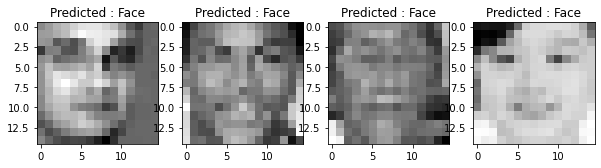

In [59]:
print('Original Faces')
plot(faces ,vj)

Original Non Faces


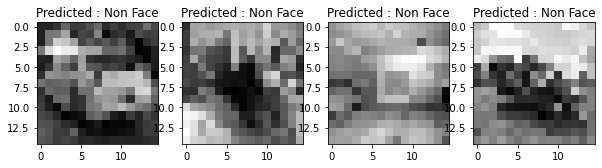

In [61]:
print('Original Non Faces')
plot(non_faces , vj)